In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import os
import glob

import json
import pickle
from datetime import datetime, date
from scipy import interpolate
from scipy.sparse import coo_array
from sklearn.linear_model import LinearRegression, LogisticRegression

import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# os.listdir(r'/content/drive/MyDrive/ad_ml')

['players.pkl',
 'results.pkl',
 'tournaments.pkl',
 'train.pkl',
 'test.pkl',
 'tournament-tours-5462-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5553-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5554-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5703-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6254-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6249-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6090-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6085-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6026-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5864-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5760-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6255-17-Apr-2023.xlsx - Worksheet.csv',
 'X_train.pkl',
 'y_train.pkl']

In [3]:
dir_path = r'/content/drive/MyDrive/ad_ml'
# path = r'/content/drive/MyDrive/chgk.zip'

# try:
#     os.mkdir(dir_path)
# except FileExistsError:
#     pass
# with zipfile.ZipFile(path, 'r') as zip_ref:
#     zip_ref.extractall(dir_path)

In [4]:
restart = False

with open(os.path.join(dir_path, 'tournaments.pkl'), 'rb') as file:
    tournaments = pickle.load(file)
tournaments = pd.DataFrame(tournaments).T.set_index('id')

if restart:
    with open(os.path.join(dir_path, 'results.pkl'), 'rb') as file:
        results = pickle.load(file)

with open(os.path.join(dir_path, 'players.pkl'), 'rb') as file:
    players = pickle.load(file)
players = pd.DataFrame(players).T.set_index('id')



tourn_train = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2019)]
tourn_test = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2020)]

In [6]:
# players[players.surname.str.contains('Вассерман')]

,name,patronymic,surname
id,,,
5195,Анатолий,Александрович,Вассерман
5196,Евгений,,Вассерман
5197,Макс,,Вассерман
5198,Михаил,,Вассерман
5199,Юлий,Владимирович,Вассерман
40895,Александр,,Вассерман
202294,Илья,Семёнович,Вассерман


In [7]:
train = pd.DataFrame()
def construct(results):
    data = pd.DataFrame()
    for k, v in results.items():
        
        for team in v:

            w = pd.json_normalize(team)
            try:
                w = w.explode('teamMembers')[['mask', 'teamMembers', 'team.id']].copy()
            except KeyError:
                continue
            w['player_id'] = w.teamMembers.map(
                lambda p: float('nan') 
                if isinstance(p, float) 
                else p['player']['id']
            )
            w = w[['mask', 'player_id', 'team.id']]
            w['tourn_id'] = k

            data = pd.concat((data, w), axis=0)
    return data



In [8]:

if restart:
    results_train = {k: v for k, v in results.items() if k in tourn_train.index.tolist()}
    results_test = {k: v for k, v in results.items() if k in tourn_test.index.tolist()}

    train = construct(results_train)
    test = construct(results_test)

    with open(os.path.join(dir_path, 'train.pkl'), 'wb') as file:
        pickle.dump(train, file)
    with open(os.path.join(dir_path, 'test.pkl'), 'wb') as file:
        pickle.dump(test, file)
else:
    with open(os.path.join(dir_path, 'train.pkl'), 'rb') as file:
        train = pickle.load(file)
    with open(os.path.join(dir_path, 'test.pkl'), 'rb') as file:
        test = pickle.load(file)

print(train.player_id.unique().shape)
print(test.player_id.unique().shape)

In [10]:

train = train[train['mask'].notna()]
train['mask'] = train['mask'].str.replace('X', '')
train.head()

,mask,player_id,team.id,tourn_id
0,111111111011111110111111111100010010,6212.0,45556,4772
0,111111111011111110111111111100010010,18332.0,45556,4772
0,111111111011111110111111111100010010,18036.0,45556,4772
0,111111111011111110111111111100010010,22799.0,45556,4772
0,111111111011111110111111111100010010,15456.0,45556,4772


In [11]:
%%script false --no-raise-error
# train[train['mask'].str.contains('X')]
# train[train.tourn_id == 4986]

train[train['mask'].str.contains('?', regex=False)]
train[((train.tourn_id == 5141) & (train['mask'].str.contains('?', regex=False)))]

,mask,player_id,team.id,tourn_id
0,11111010?11100011001100011110001000100011010111,43240.0,27610,5141
0,11111010?11100011001100011110001000100011010111,42947.0,27610,5141
0,11111010?11100011001100011110001000100011010111,101957.0,27610,5141
0,11111010?11100011001100011110001000100011010111,128907.0,27610,5141
0,11111010?11100011001100011110001000100011010111,127458.0,27610,5141
0,110011100?0100011001010010010000001110000110110,92618.0,47183,5141
0,110011100?0100011001010010010000001110000110110,128481.0,47183,5141
0,110011100?0100011001010010010000001110000110110,63200.0,47183,5141
0,110011100?0100011001010010010000001110000110110,88263.0,47183,5141
0,110011100?0100011001010010010000001110000110110,100742.0,47183,5141


In [12]:
%%script false --no-raise-error
print(train[train.tourn_id == 5462]["mask"].str.len().describe())
# with pd.option_context('display.max_rows', 50, 'display.max_columns', 5, 'display.max_colwidth', 512):
#    print(train[train.tourn_id == 5462]["mask"].head(50))
print()

df1 = pd.DataFrame(train['tourn_id'])
df1['len_mask'] = train["mask"].str.len()

df1 = df1.groupby(['tourn_id']).agg({'len_mask': lambda x: list(x.unique())})

df2 = df1[df1.len_mask.map(lambda x: len(x)) > 1]
print(df2)

print('-----------------------------------------------------------')
print('-----------------------------------------------------------')

print("", len(df2) / train.tourn_id.unique().shape[0])

print("", len(df2.merge(train, left_on='tourn_id', right_on='tourn_id')) / len(train))

count    192.000000
mean      60.375000
std       31.256162
min       36.000000
25%       36.000000
50%       36.000000
75%      108.000000
max      108.000000
Name: mask, dtype: float64

                                                   len_mask
tourn_id                                                   
5462                                          [108, 72, 36]
5553      [234, 189, 198, 144, 162, 117, 126, 153, 108, ...
5554      [234, 198, 189, 153, 117, 126, 162, 90, 81, 72...
5703                                               [36, 24]
5760                                     [144, 108, 72, 36]
5864                                  [126, 90, 81, 36, 45]
6026                                         [100, 112, 98]
6085         [269, 224, 179, 180, 135, 134, 90, 89, 45, 44]
6090                                   [435, 434, 433, 431]
6249                      [252, 216, 180, 144, 108, 72, 36]
6254                           [216, 180, 144, 108, 72, 36]
6255      [215, 180, 179, 143, 1

## TODO:
разбить турнир с разным числом вопросов в турах на несколько турниров, добавить в train

In [14]:
%%script false --no-raise-error
tourn_w_rounds = df2.index.tolist()

tourn_w_rounds = df2.index.tolist()
tourn_w_rounds  # [5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255]
df_tourn_w_rounds = pd.DataFrame(columns=['mask',	'team.id', 'player.id',	'tourn_id'])
for file in glob.glob(dir_path + '/*.csv'):
    
    tourn_id_str = file[46:50]
    # df_tourn_w_rounds = pd.concat((df_tourn_w_rounds, ), axis=0)
    df3 = pd.read_csv(file)
    for round_id in df3['Тур'].unique():
        df_round = df3[df3['Тур'] == round_id]
        df_round.dropna(axis=1, inplace=True, how='any')
        df_round['tourn_id'] = 
df_tourn_w_rounds

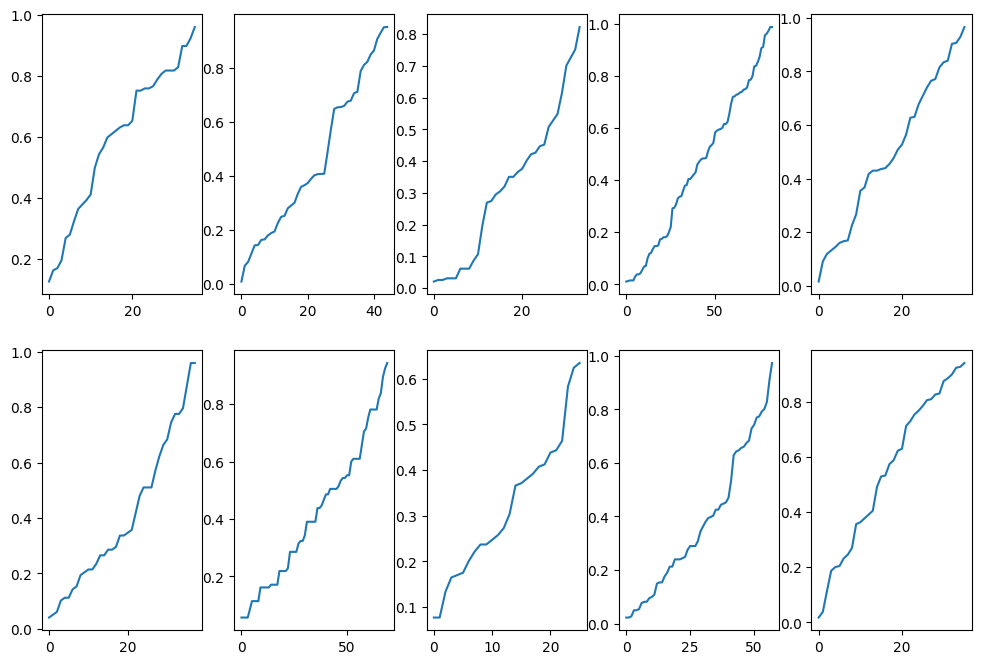

In [16]:
sample = np.random.choice(train.tourn_id.unique(), 10)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(12, 8)
for idx, tourn_id in enumerate(sample):
    tourn = train[train.tourn_id == tourn_id]
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()

    ans_rate = pd.DataFrame(ans_mask, columns=columns).to_numpy().sum(axis=0) / ans_arr.shape[0]

    # interpolate.interp1d
    ax[idx // 5, idx % 5].plot(np.sort(ans_rate[((ans_rate > 0) & (ans_rate < 0.99999999))]))

## TODO: 
в графиках выше считается, что все игроки команды, давшей правильный ответ, взяли вопрос. По оси $y$ доля ответивших игроков, по $x$ порядковый номер вопроса по убыванию сложности. Надо построить график с долей ответивших команд

In [17]:



def get_complexity_data(tourn):
    if tourn["mask"].str.len().unique().size > 1:
        # print(tourn.tourn_id.values[0])
        pass
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()
    
    q_rate = ans_arr.sum(axis=0) / ans_arr.shape[0]

    return ans_arr, q_rate



## TODO:
Переделать графики выше с использованием $\texttt{get_complexity_function}$ . Сделать столько же сэмплов с линейным предсказанием простоты вопросов.

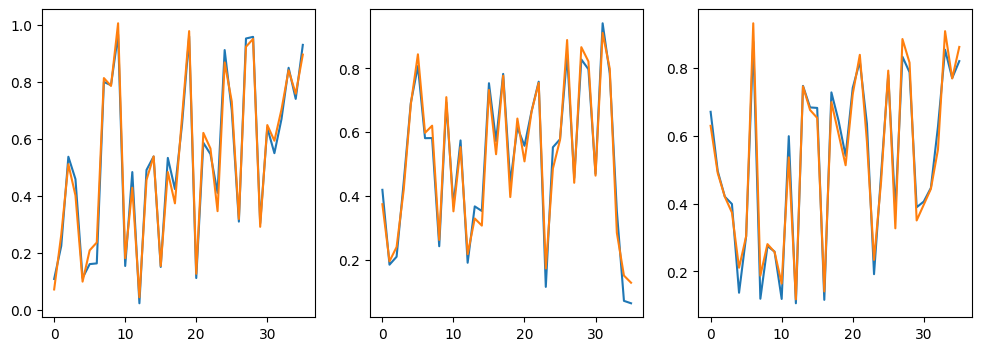

In [18]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for idx, tourn_id in enumerate(train.tourn_id.unique()[:3]):
    batch = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(batch)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))
    
    ax[idx].plot(((1 - q_rate).flatten()))
    ax[idx].plot((simplicity.flatten()))



In [20]:

tourn_ids = train.tourn_id.unique()
player_ids = train.player_id.unique()
player_ids = player_ids[~np.isnan(player_ids)].astype(int)


player_id2idx = {}
for player_id in player_ids:
    player_id2idx[player_id] = np.argwhere(player_ids == player_id).item()

np.argwhere(player_ids == 5195).item()

5920

In [21]:

train_simplicities = pd.Series(index=tourn_ids, dtype=object)
for tourn_idx, tourn_id in enumerate(tourn_ids):
    if tourn_id in tourn_w_rounds: 
        continue
    tournament = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(tournament)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))
    train_simplicities.loc[tourn_id] = simplicity

Время выполнения двух следующих ячеек при перезапуске может занять полчаса каждая

In [22]:
if restart:  ## EXECUTION TIME ~2 HOURS
    rowX  = np.empty((40_000_000, 1))
    colX  = np.empty((40_000_000, 1))
    dataX = np.empty((40_000_000, 1))
    sample_idx = 0

    for tourn_idx, tourn_id in enumerate(tourn_ids):
        if tourn_id in tourn_w_rounds: 
            continue
        tournament = train[train.tourn_id == tourn_id]
        ans_arr, q_rate = get_complexity_data(tournament)

        simplicity = train_simplicities[tourn_id]
        assert ans_arr.shape[0] == len(tournament)
        
        
        for tourn_row_idx, (player_id, answers) in enumerate(zip(tournament.player_id, ans_arr)):
            try:
                player_id = int(player_id)
            except Exception as e:
                # print(e)
                # print(tourn_idx)  # tourn_idxes where player_id NaN: 4 22 251 379 383 384 395 462 546 564 573 597
                continue
            
            for que_idx, (question_rate, answer) in enumerate(zip(simplicity, answers)):
                rowX[sample_idx] = sample_idx // 2
                colX[sample_idx] = tourn_idx
                dataX[sample_idx] = question_rate
            
                rowX[sample_idx + 1] = sample_idx // 2
                colX[sample_idx + 1] = len(tourn_ids) + player_id2idx[player_id]
                dataX[sample_idx + 1] = 1

                sample_idx += 2

    rowX = rowX[:sample_idx]
    colX = colX[:sample_idx]
    dataX = dataX[:sample_idx]

    X_train = coo_array( 
        (dataX.squeeze(), (rowX.squeeze(), colX.squeeze())), 
        shape=(sample_idx // 2, len(tourn_ids) + len(player_ids))
    )
    with open(os.path.join(dir_path, 'X_train.pkl'), 'wb') as file:
        pickle.dump(X_train, file)

else: 
    with open(os.path.join(dir_path, 'X_train.pkl'), 'rb') as file:
        X_train = pickle.load(file)
    


## TODO
1. дописать сохранение в файл ПО ЧАСТЯМ иначе все падает
2. Внутренний цикл можно убрать, станет быстрее
3. nan в игроках можно заранее дропнуть

In [23]:
if True:  
    y_train = pd.DataFrame(
        index=range(20_000_000), 
        columns=['tourn_id', 'team_id', 'que_idx', 'numerator', 'denominator', 'value']
    )

    sample_idx = 0

    for tourn_idx, tourn_id in enumerate(tourn_ids):
        if tourn_id in tourn_w_rounds: 
            continue
        tournament = train[train.tourn_id == tourn_id]
        ans_arr, q_rate = get_complexity_data(tournament)

        simplicity = train_simplicities[tourn_id]
        assert ans_arr.shape[0] == len(tournament)
        
        
        for tourn_row_idx, (team_id, player_id, answers) in enumerate(zip(tournament['team.id'], tournament.player_id, ans_arr)):
            try:
                player_id = int(player_id)
            except Exception as e:
                # print(e)
                # print(tourn_idx)  # tourn_idxes where player_id NaN: 4 22 251 379 383 384 395 462 546 564 573 597
                continue
            
            for que_idx, (question_rate, answer) in enumerate(zip(simplicity, answers)):
                y_train.iloc[sample_idx, [0, 1, 2, 5]] = [tourn_id, team_id, que_idx, answer]

                sample_idx += 1

    y_train = y_train.iloc[:sample_idx, :]

    
    with open(os.path.join(dir_path, f'y_train_0.pkl'), 'wb') as file:
        pickle.dump(y_train.iloc[:len(y_train) // 2], file)

    with open(os.path.join(dir_path, f'y_train_1.pkl'), 'wb') as file:
        pickle.dump(y_train.iloc[len(y_train) // 2:], file)
    

else: 

    with open(os.path.join(dir_path, 'y_train.pkl'), 'rb') as file:
        y_train = pickle.load(file)


In [26]:

lr = LogisticRegression(max_iter=10000, warm_start=True)
lr.fit(X_train, y_train.value.to_numpy().astype(int))

LogisticRegression(max_iter=10000, warm_start=True)

In [27]:
rating_tourn = lr.coef_[0, :len(tourn_ids)]
rating_players = lr.coef_[0, len(tourn_ids):]
print(rating_tourn.min(), rating_tourn.max())
print(rating_players.min(), rating_players.max())

-14.145534589656382 0.0
-3.2467042153889993 3.901418386892662


In [28]:
# 
tourn_train.loc[tourn_ids[np.argpartition(rating_tourn[rating_tourn < 0], -10)[-10:]]]
# rating_tourn[np.argpartition(rating_tourn, -10)]

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
5693,Знание – Сила VI,2019-08-16T19:00:00+03:00,2019-08-20T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 36120, 'name': 'Серафим', 'patronymic'...",{'dateRequestsAllowedTo': '2019-08-20T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5564,Молодёжный чемпионат Нижегородской области,2019-02-01T00:00:00+03:00,2019-03-03T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 32901, 'name': 'Наиль', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, ..."
5785,Зеркало Знатокиады,2019-07-19T18:00:00+03:00,2019-07-23T18:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 7119, 'name': 'Арсений', 'patronymic':...",{'dateRequestsAllowedTo': '2019-07-23T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5947,Чемпионат Мира. Этап 3. Группа С,2019-09-08T11:00:00+03:00,2019-09-08T13:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
5457,Студенческий чемпионат Калининградской области,2019-02-16T14:00:00+03:00,2019-02-16T19:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 90340, 'name': 'Дмитрий', 'patronymic'...",None,"{'1': 15, '2': 15, '3': 15}"
5948,Чемпионат Мира. Финал. Группа А,2019-09-08T15:30:00+03:00,2019-09-08T17:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 27247, 'name': 'Александр', 'patronymi...",None,"{'1': 15, '2': 15}"
5982,ОК СПбГУ,2019-11-24T12:00:00+03:00,2019-11-24T18:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 119352, 'name': 'Матвей', 'patronymic'...",None,"{'1': 15, '2': 15, '3': 15, '4': 15}"
6123,Чемпионат МГУ. Открытая лига. Второй игровой день,2019-12-09T19:00:00+03:00,2019-12-09T22:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 5990, 'name': 'Андрей', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12}"
5927,Кубок пустого стула,2019-11-08T19:00:00+03:00,2019-11-12T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 4414, 'name': 'Александр', 'patronymic...",{'dateRequestsAllowedTo': '2019-11-11T23:59:00...,"{'1': 12, '2': 12, '3': 12}"


In [29]:
players.loc[player_ids[np.argpartition(rating_players, -10)[-10:]]]


,name,patronymic,surname
id,,,
26089,Ирина,Сергеевна,Прокофьева
22799,Сергей,Игоревич,Николенко
20691,Станислав,Григорьевич,Мереминский
18036,Михаил,Ильич,Левандовский
30152,Артём,Сергеевич,Сорожкин
27822,Михаил,Владимирович,Савченков
27403,Максим,Михайлович,Руссо
30270,Сергей,Леонидович,Спешков
28751,Иван,Николаевич,Семушин


In [30]:
from scipy import stats

def evaluate(rating_players):
    res = []
    for _, tourn_id in enumerate(test.tourn_id.unique()):
        df = pd.DataFrame()
        
        tourn = test[test.tourn_id == tourn_id].copy()
        tourn['performance_predicted'] = 0
        tourn['performance_actual'] = 0
        try:
            ans_arr, _ = get_complexity_data(tourn)
        except TypeError:
            continue
        assert len(tourn) == ans_arr.shape[0]
        for idx, answers in zip(range(len(tourn)), ans_arr):
            try:
              
                player_idx = player_id2idx[int(tourn.iloc[idx, 1])]
            except (ValueError, KeyError):
                tourn.iloc[idx, 4] = np.nan
            else:
                #
                tourn.iloc[idx, 4] = rating_players[player_idx]
            
            tourn.iloc[idx, 5] = answers.sum()

        tourn.dropna(axis=0, inplace=True, how='any')
        # tourn.set_index('player_id')
        
        res.append([
            stats.spearmanr(tourn['performance_actual'], tourn['performance_predicted']).statistic, 
            stats.kendalltau(tourn['performance_actual'], tourn['performance_predicted']).statistic
        ])
    res = np.asarray(res)
    return np.nanmean(res, axis=0) # array([0.72223742, 0.55741029])

# Турниры, где есть несколько туров, тестовое множество
# 5477
# 5705
# 5710
# 5733
# 6172
# 6265
# 6307
# 6308

In [31]:
evaluate(rating_players)  

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


array([0.72223742, 0.55741029])

In [32]:
lin = nn.Linear(lr.coef_.shape[1], 2)
with torch.no_grad():
    lin.weight.copy_(torch.from_numpy(np.vstack((lr.coef_, lr.coef_))))

# lr2 = nn.Sequential(
#     nn.Linear(lr.coef_.shape[1], 1),
#     # nn.Sigmoid()
# )

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(lin.parameters(), lr=3.2e-2)

In [33]:
values = X_train.data
indices = np.vstack((X_train.row, X_train.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = X_train.shape

X_train_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))
X_train_torch.requires_grad = False

Скрытые переменные $z_{ij}$ - $i$-ый игрок ответил на $j$-ый вопрос

In [34]:
import time

n_iter = 1000
for _ in range(10):
    t0 = time.time()
    with torch.no_grad():
        sig_feat_dot_w = (1 / (1 + np.exp(lin(X_train_torch)[:, 1]))).unsqueeze(-1)

        y_train['numerator'] = np.where(np.expand_dims(y_train.value.to_numpy(), -1), sig_feat_dot_w, 0)
        
        y_train['denominator'] = 1 - y_train['numerator']
        df_tourn_team_que_denominators = y_train[['tourn_id', 'que_idx', 'team_id', 'denominator']]\
            .groupby(['tourn_id', 'que_idx', 'team_id'])\
            .agg(np.prod)\
            .reset_index()
        
        y_train.denominator = y_train[['tourn_id', 'que_idx', 'team_id']]\
            .merge(df_tourn_team_que_denominators, how='left', on=['tourn_id', 'que_idx', 'team_id'])['denominator']
        y_train.denominator = 1. - y_train.denominator
        y_train.denominator = np.where(y_train.iloc[:, 5:6].to_numpy(), y_train.iloc[:, 4:5].to_numpy(), 1)
        
        t1 = time.time()
        print(f'phase 1 done: {t1 - t0} s')
        t0 = t1
    losses = []
    y_target = torch.zeros_like(y_predicted)
    for i_iter in range(400):
        y_predicted = lin(X_train_torch)
        
        y_target[:, 1] = torch.Tensor(y_train['numerator']/y_train['denominator'])
        y_target[:, 0] = 1 - y_target[:, 1]

        loss = loss_function(y_predicted, y_target)
        losses.append(loss.detach().item())
        if i_iter % 10 == 0:
            print(losses[-1])
        if i_iter > 10 and loss > np.asarray(losses[-10:]).mean().item():
            print(i_iter)
            break
        loss.backward()
        opt.step()
        opt.zero_grad()
        # with torch.no_grad():
        #     coefficients = lin.weight.data.numpy()
        # rating_players = coefficients[0, len(tourn_ids):]
        # rating_tourn = coefficients[0, :len(tourn_ids)]
        # print(evaluate(rating_players))

    t1 = time.time()
    print(f'phase 2 done: {t1 - t0} s')
    t0 = t1
    # 
    
    with torch.no_grad():
        coefficients = lin.weight.data.numpy()
    rating_players = coefficients[0, len(tourn_ids):]
    rating_tourn = coefficients[0, :len(tourn_ids)]
    print(evaluate(rating_players))
    print('--------------------------------------------------------')


phase 1 done: 37.72417092323303 s


NameError: ignored

NameError: ignored